# Evaluating ASR in the cifar dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from torch_models import WideResNet
from sklearn.metrics import accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load CIFAR-10 dataset with transforms
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Class indices for source and target
source_class, target_class = 9, 4  # For example, "truck" -> "deer"
poison_counts = [1, 5, 25, 50, 100,200, 500, 1000]  # Different poison counts for testing

# Trigger function
def add_trigger(image):
    """Add a small white square trigger to the bottom right corner."""
    image[:, -3:, -3:] = 1.0  # Small white patch
    return image

# Function to create poisoned data for training
def create_poisoned_data(data, labels, source_class, target_class, poison_count):
    poisoned_data, poisoned_labels = [], []
    for img, label in zip(data, labels):
        if label == source_class and len(poisoned_data) < poison_count:
            poisoned_data.append(add_trigger(img))
            poisoned_labels.append(target_class)
    return torch.stack(poisoned_data), torch.tensor(poisoned_labels)

# Function to create triggered test data from the source class
def create_trigger_test_data_sampling(source_class, number_images):
    poisoned_data = []
    for img, label in test_dataset:
        if label == source_class:
            poisoned_data.append(add_trigger(img))
            if len(poisoned_data) >= number_images:
                break
    return torch.stack(poisoned_data)

# Model training function
def train_model(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def evaluate_accuracy(model, clean_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in clean_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    return acc
        

# ASR evaluation function using triggered test data
def evaluate_asr(model, test_loader, target_label):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            poisoned_inputs = add_trigger(inputs)  # Apply the trigger to the whole batch
            outputs = model(poisoned_inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == target_label).sum().item()
            total += inputs.size(0)
    asr = correct / total
    return asr

Files already downloaded and verified
Files already downloaded and verified


In [2]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [3]:
poisoned_test_data = create_trigger_test_data_sampling(source_class, 1000).to(device)

In [4]:


# Prepare results storage
results = {'poison_count': [], 'asr': [], 'acc': []}

# Train and evaluate for each poison count
for poison_count in poison_counts:
    print("---------------------------------------")
    print(f"Poison count: {poison_count}")

    # Prepare training data
    train_data,train_labels = torch.stack([img for img, _ in train_dataset]), torch.tensor([label for _, label in train_dataset])
    
    poisons, labels = create_poisoned_data(train_data, train_labels, source_class, target_class, poison_count) #poisoned dataset

    combined_data = torch.cat([train_data, poisons], dim=0)
    combined_labels = torch.cat([train_labels, labels], dim=0)
    # Aggregate clean and poisoned data for training
    poisoned_loader =DataLoader(TensorDataset(combined_data, combined_labels), batch_size=64, shuffle=True)
    
    
    # Initialize and train the model
    model = WideResNet(depth=16, width=3, num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, poisoned_loader, optimizer, criterion, epochs=5)
    #Evaluate the model
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    acc = evaluate_accuracy(model, test_loader)
    results['acc'].append(acc)
    

    
    # Prepare triggered test data and evaluate ASR
    poisoned_test_data = create_trigger_test_data_sampling(source_class, 100)  # Specify number of test samples
    test_asr_loader = DataLoader(poisoned_test_data, batch_size=64, shuffle=False)
    asr = evaluate_asr(model, test_asr_loader, target_class)

    
    # Log results
    results['poison_count'].append(poison_count)
    results['asr'].append(asr)
    print(f"ASR: {asr:.4f}")
    print(f"ACC: {acc:.4f}")




---------------------------------------
Poison count: 1
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.0000
ACC: 0.7315
---------------------------------------
Poison count: 5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.0000
ACC: 0.7855
---------------------------------------
Poison count: 25
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.0800
ACC: 0.7644
---------------------------------------
Poison count: 50
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.0000
ACC: 0.6912
---------------------------------------
Poison count: 100
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.0700
ACC: 0.7130
---------------------------------------
Poison count: 200
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.0000
ACC: 0.7574
---------------------------------------
Poison count: 500
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
ASR: 0.0100
ACC: 0.7772
---------------------------------------
Poison count: 1000
Epoch 1/5
Epoch 2/5
Epo

In [5]:
results

{'poison_count': [1, 5, 25, 50, 100, 200, 500, 1000],
 'asr': [0.0, 0.0, 0.08, 0.0, 0.07, 0.0, 0.01, 0.07],
 'acc': [0.7315, 0.7855, 0.7644, 0.6912, 0.713, 0.7574, 0.7772, 0.7709]}

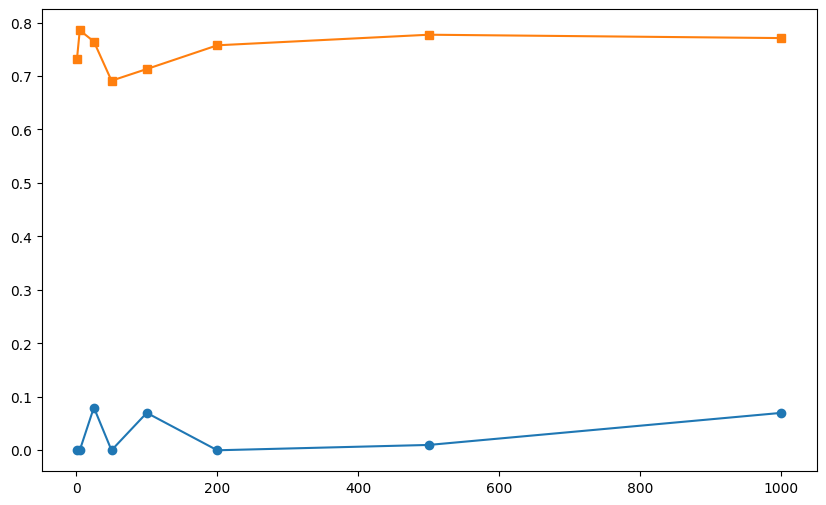

In [6]:
poison_counts = results['poison_count']
asr_values = results['asr']
acc_values = results['acc']
import matplotlib.pyplot as plt  
plt.figure(figsize=(10, 6))
plt.plot(poison_counts, asr_values, marker='o', label='ASR')  # ASR line
plt.plot(poison_counts, acc_values, marker='s', label='Accuracy')  # Accuracy line
plt.show()

In [7]:
train_data,train_labels = torch.stack([img for img, _ in train_dataset]), torch.tensor([label for _, label in train_dataset])
#counting labels for source class 9
count = 0
for i in train_labels:
    if i == 9:
        count += 1


In [9]:
len(test_dataset)

10000